In [1]:
import sys
import os

current_directory = os.getcwd()        # '/home/bear-b/users/jshi008/IvyProjects/FIDLA/train_WaLeF_models'
parent_directory = os.path.dirname(current_directory)    # '/home/bear-b/users/jshi008/IvyProjects/FIDLA'
sys.path.append(parent_directory)

from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process
from preprocess.graph import graph_topology_5
from models.graph_water_transformer_cov import Graph_Water_Transformer_Cov

import torch
import torch.utils.data as data_utils

import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Parameters

In [2]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5


# ===== model parameters ======
head_size = 96*2
num_heads = 3
ff_dim = 96
num_transformer_blocks = 1
dropout = 0.5
atte_reg = 1e-2
l1_reg = 1e-5
l2_reg = 1e-5
gcn_unit1 = 32
gcn_unit2 = 16
lstm_units = 32
learning_rate = 5e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512

### Preprocess

In [3]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = graph_water_transformer_cov_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


#### Graph topology

In [4]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


In [5]:
train_cov, train_tws_reshape, train_adj_mat, train_ws_y = torch.tensor(train_cov), torch.tensor(train_tws_reshape), torch.tensor(train_adj_mat), torch.tensor(train_ws_y)
test_cov, test_tws_reshape, test_adj_mat, test_ws_y = torch.tensor(test_cov), torch.tensor(test_tws_reshape), torch.tensor(test_adj_mat), torch.tensor(test_ws_y)

In [6]:
train_cov.shape, train_tws_reshape.shape, train_adj_mat.shape, train_ws_y.shape

(torch.Size([77069, 96, 12]),
 torch.Size([77069, 5, 72]),
 torch.Size([77069, 5, 5]),
 torch.Size([77069, 96]))

In [22]:
batch_size = 512*3
train_loader = data_utils.DataLoader(data_utils.TensorDataset(train_cov, train_tws_reshape, train_adj_mat, train_ws_y), batch_size=batch_size, shuffle=True)
# val_loader = data_utils.DataLoader(data_utils.TensorDataset(val_X_mask, val_ws_y), batch_size=batch_size, shuffle=True)
test_loader = data_utils.DataLoader(data_utils.TensorDataset(test_cov, test_tws_reshape, test_adj_mat, test_ws_y), batch_size=batch_size, shuffle=True)

### Model

In [23]:
input_shape = train_cov.shape[1:]
input_shape

torch.Size([96, 12])

In [24]:
model = Graph_Water_Transformer_Cov(input_shape,  num_heads, dropout, epsilon, lstm_units, num_transformer_blocks, gcn_unit1, gcn_unit2, ff_dim)
model = model.to(device)
train_losses = []
val_losses = []

In [25]:
# from torchinfo import summary
# summary(model, 
#         input_data=[*next(iter(train_loader))[:-2], next(iter(train_loader))[-2][0]],
#         device='cuda'
#         )

In [26]:
model.load_state_dict(torch.load(r"../saved_model/WaLeF_gtn_p.pth"))

<All keys matched successfully>

In [27]:

learning_rate = 3e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = ExponentialLR(optimizer, gamma=decay_rate,
#                         #   last_epoch=-1
#                           )
from torchmetrics.regression import MeanAbsoluteError
criterion = torch.nn.MSELoss()
MAE = MeanAbsoluteError().to(device)

total_num_epochs = 0
num_epochs = 150

Epoch: 118 - Train Loss: 1.625e-04 - Val Loss: 4.964e-04 - 
Train MAE: 0.00797 - Val MAE: 0.01677


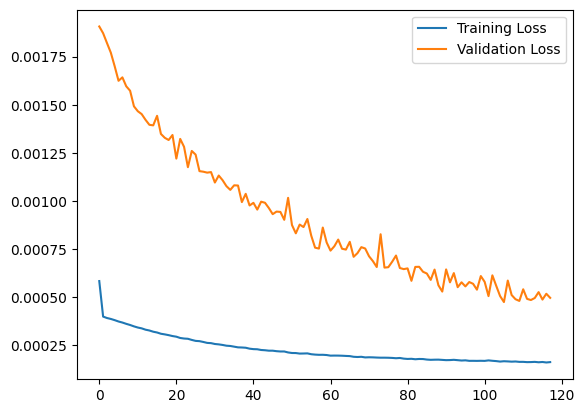

 79%|███████▊  | 118/150 [26:18<07:08, 13.38s/it]


KeyboardInterrupt: 

In [28]:
for epoch in tqdm(range(num_epochs)):
    total_num_epochs += epoch
    model.train()
    total_train_loss = 0
    total_train_mae = 0
    
    for batch in train_loader:
        cov, tws, adj_mat, ws_y = batch[0].to(device), batch[1].to(device), batch[2].to(device), batch[3].to(device)
        optimizer.zero_grad()
        m_out = model(cov, tws, adj_mat[0])
        loss = criterion(m_out, ws_y)
        mae_train = MAE(m_out, ws_y)
        loss.backward()
        optimizer.step()
        # scheduler.step()
        total_train_loss += loss.item()
        total_train_mae += mae_train.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_mae = total_train_mae / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    total_val_loss = 0
    total_val_mae = 0
    with torch.no_grad():
        for batch in test_loader:
            cov, tws, adj_mat, ws_y = batch[0].to(device), batch[1].to(device), batch[2].to(device), batch[3].to(device)
            m_out = model(cov, tws, adj_mat[0])
            loss = criterion(m_out, ws_y)
            mae_val = MAE(m_out, ws_y)
            total_val_loss += loss.item()
            total_val_mae += mae_val.item()
    
    avg_val_loss = total_val_loss / len(test_loader)
    avg_val_mae = total_val_mae / len(test_loader)
    val_losses.append(avg_val_loss)
    
    display.clear_output(wait=True)
    print(f"Epoch: {epoch+1} - Train Loss: {avg_train_loss:.3e} - Val Loss: {avg_val_loss:.3e} - \nTrain MAE: {avg_train_mae:.5f} - Val MAE: {avg_val_mae:.5f}")
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.show(block=False)

    if len(val_losses) > 1:
        if val_losses[-1] < val_losses[-2]:
            torch.save(model.state_dict(), '../saved_model/WaLeF_gtn_p.pth')

# Epoch 1021: val_mae did not improve from 0.01093
# loss: 1.0462e-04 -     mae: 0.0058 - 
# val_loss: 2.9385e-04 - val_mae: 0.0124

